In [70]:
import pandas as pd
import seaborn as sns
import xgboost as xgb
import numpy as np
import matplotlib.pyplot as plt
import tldextract
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from xgboost import plot_importance
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.feature_selection import SelectFromModel

plt.rcParams['figure.figsize'] = (14.0, 5.0)
plt.rcParams['axes.grid'] = True

sns.set()
%matplotlib inline


In [24]:
# This is the Alexa 100k domain list, we're not using the 1 Million just for speed reasons. Results
# for the Alexa 1M are given at the bottom of the notebook.
alexa_dataframe = pd.read_csv('data/alexa_100k.csv', names=['rank','uri'], header=None, encoding='utf-8')
alexa_dataframe.head()

,rank,uri
0,1,facebook.com
1,2,google.com
2,3,youtube.com
3,4,yahoo.com
4,5,baidu.com


In [25]:
def domain_extract(uri):
    ext = tldextract.extract(uri)
    if (ext.suffix):
        return ext.domain
    return np.nan
        
alexa_dataframe['domain'] = [ domain_extract(uri) for uri in alexa_dataframe['uri']]
del alexa_dataframe['rank']
del alexa_dataframe['uri']
print(alexa_dataframe.shape)
alexa_dataframe.head()

(100000, 1)


,domain
0,facebook
1,google
2,youtube
3,yahoo
4,baidu


In [26]:
alexa_dataframe = alexa_dataframe.dropna()
alexa_dataframe = alexa_dataframe.drop_duplicates()
alexa_dataframe['class'] = 'legit'
alexa_dataframe = alexa_dataframe.reindex(np.random.permutation(alexa_dataframe.index))
alexa_dataframe.head()

,domain,class
40863,funkyimg,legit
70979,h-opera,legit
3158,pideo,legit
93449,johnnymoneyseed,legit
52732,learni,legit


In [27]:
alexa_dataframe.shape

(91376, 2)

In [32]:
dga_dataframe = pd.read_csv('data/dga_domains.txt', names=['raw_domain'], header=None, encoding='utf-8')
dga_dataframe['domain'] = dga_dataframe.applymap(lambda x: x.split('.')[0].strip().lower())
del dga_dataframe['raw_domain']
dga_dataframe = dga_dataframe.dropna()
dga_dataframe = dga_dataframe.drop_duplicates()
dga_dataframe['class'] = 'dga'
print(dga_dataframe.shape)
dga_dataframe.head()

(2664, 2)


,domain,class
0,04055051be412eea5a61b7da8438be3d,dga
1,1cb8a5f36f,dga
2,30acd347397c34fc273e996b22951002,dga
3,336c986a284e2b3bc0f69f949cb437cb,dga
5,40a43e61e56a5c218cf6c22aca27f7ee,dga


In [38]:
all_domains = pd.concat([alexa_dataframe, dga_dataframe], ignore_index=True)
all_domains['length'] = [len(x) for x in all_domains['domain']]

all_domains.head()

,domain,class,length
0,funkyimg,legit,8
1,h-opera,legit,7
2,pideo,legit,5
3,johnnymoneyseed,legit,15
4,learni,legit,6


http://rosettacode.org/wiki/Entropy#Python:_More_succinct_version

In [39]:
import math
from collections import Counter
 
def entropy(s):
    p, lns = Counter(s), float(len(s))
    return -sum( count/lns * math.log(count/lns, 2) for count in p.values())

In [40]:

all_domains['entropy'] = [entropy(x) for x in all_domains['domain']]

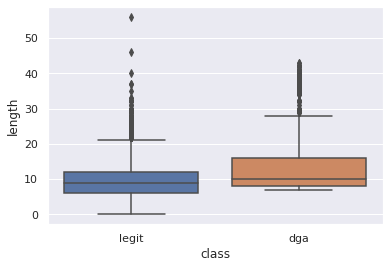

In [56]:
sns.boxplot(x=all_domains['class'],y=all_domains['length'])


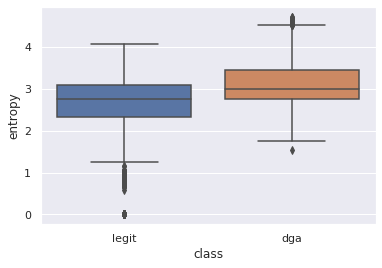

In [57]:
sns.boxplot(x=all_domains['class'],y=all_domains['entropy'])

In [66]:
X = all_domains[['length', 'entropy']]
Y = all_domains[['class']]

/home/sandeepnl/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/sandeepnl/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


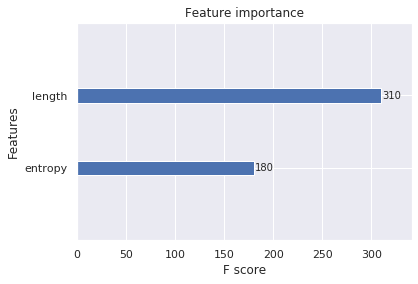

In [73]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.33, random_state=7)

# fit model to training data
model = XGBClassifier()
model.fit(X_train, y_train)
# print(model)
# print(model.feature_importances_)
# get feature importance from builtin function.
ax = plot_importance(model)
fig = ax.figure
plt.show()

In [74]:
# make predictions for test data and evaluate
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)

print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 97.68%
